### Installations

In [1]:
# !pip install google-adk google-cloud-aiplatform google-genai
# gcloud auth application-default login

### Simple Agent without Tools

A simple ADK AI agent is just a small Python object that wraps a language-model (like Gemini) with a bit of personality and optional tools so it can chat, reason, and act in your code or cloud project. 

#### What it is?
Tiny wrapper, big brain – you pick a foundation model, give it a name, an instruction, and (optionally) a list of functions it may call; ADK turns that into an “agent” ready to receive messages. 

* Stateful by default – ADK handles the chat history and context so each reply feels coherent without you wiring up databases yourself. 
* Plug-and-play – the exact same agent code can run locally with an API key or remotely on Vertex AI with a single flag change. 


#### Why it matters?
* Lets beginners build useful conversational helpers in minutes instead of wiring REST calls by hand. 
* Scales up: the same construct can orchestrate tools, call other agents, and deploy as a micro-service when you’re ready for more. 

In [ ]:
"""
A minimal ADK agent that streams responses from Gemini-Flash on Vertex AI.
"""
import os
import asyncio
import warnings
import logging
from dotenv import load_dotenv
import vertexai                               
from google.adk.agents import Agent
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from google.genai import types                

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)
load_dotenv()                                

# ── Vertex-AI initialisation ─────────────────────────────────────────────────
PROJECT_ID  = os.environ["GOOGLE_CLOUD_PROJECT"]
LOCATION    = os.environ["GOOGLE_CLOUD_LOCATION"]
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "True"  
vertexai.init(project=PROJECT_ID, location=LOCATION)

# ── Agent definition ─────────────────────────────────────────────────────────
MODEL_GEMINI_FLASH = "gemini-2.0-flash"

simple_agent = Agent(
    name="simple_chat_agent",
    model=MODEL_GEMINI_FLASH,
    description="A helpful conversational AI assistant.",
    instruction=(
        "You are a friendly and helpful AI assistant able to discuss many topics. "
        "Be conversational, engaging, and helpful. "
        "You have no external tools; rely on knowledge only."
    ),
    tools=[],
)

session_service = InMemorySessionService()  # good for local dev; production can target Vertex Agent Engine
APP_NAME  = "simple_chat_app"
USER_ID   = "user_123"
SESSION_ID = "session_001"

async def chat_with_agent(query: str, runner: Runner):
    print(f"\n🧑 You: {query}")
    content = types.Content(role="user", parts=[types.Part(text=query)])

    async for event in runner.run_async(
        user_id=USER_ID,
        session_id=SESSION_ID,
        new_message=content,
    ):
        if event.is_final_response() and event.content and event.content.parts:
            answer = event.content.parts[0].text
            print(f"🤖 Agent: {answer.replace('**','')}")

async def main():
    # Create or fetch session
    await session_service.create_session(
        app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID
    )

    # Runner tied to our agent & session store
    runner = Runner(agent=simple_agent, app_name=APP_NAME, session_service=session_service)

    # Single-turn test
    await chat_with_agent("Hello! How are you today?", runner)

    # Multi-turn demo
    for msg in [
        "Hi there! What's your name?",
        "What can you help me with?",
        "Tell me an interesting fact about space."
    ]:
        await chat_with_agent(msg, runner)
        await asyncio.sleep(0.5)

await main()


🧑 You: Hello! How are you today?
🤖 Agent: Hello there! I'm doing well, thank you for asking. As an AI, I don't experience emotions like humans do, but I'm functioning optimally and ready to assist you with any questions or tasks you might have. How are you doing today?


🧑 You: Hi there! What's your name?
🤖 Agent: Hi! I don't have a personal name in the way humans do. You can think of me as simple_chat_agent, a helpful conversational AI assistant. I'm here to help you!


🧑 You: What can you help me with?
🤖 Agent: I can help you with a wide range of things! Here are some examples:

*   Answering questions: I can provide information on a vast array of topics, from science and history to current events and pop culture.
*   Generating text: I can write different kinds of creative content, like poems, code, scripts, musical pieces, email, letters, etc. I will try my best to fulfill all your requirements.
*   Summarizing text: I can condense long articles or documents into shorter, more man

### With Tool Use

In ADK a “tool” is simply a small, well-described function (or even another agent) that the language-model can call when it needs to do something the model alone can’t—like run a web search, hit an API, query a database, or execute code.

| Category               | What it covers                                                   | Handy examples                                                                            |
| ---------------------- | ---------------------------------------------------------------- | ----------------------------------------------------------------------------------------- |
| **Built-in**           | Ready to use, maintained by Google.                              | `google_search`, `code_execution`, `vertex_ai_search`, `bigquery` ([google.github.io][1]) |
| **Function tools**     | Your own Python/Java methods (sync, async, or long-running).     | Any bespoke business logic ([google.github.io][2])                                        |
| **Third-party**        | Drop-in adapters from libraries like LangChain or CrewAI.        | RAG or workflow utilities ([google.github.io][2])                                         |
| **Google Cloud tools** | Wrappers for Vertex, Firestore, etc., surfaced as tools.         | Cloud-native data access ([cloud.google.com][3])                                          |
| **Agents-as-tools**    | You can package a specialist agent and let other agents call it. | A “math-solver” sub-agent ([google.github.io][2])                                         |

[1]: https://google.github.io/adk-docs/tools/built-in-tools/ "Built-in tools - Agent Development Kit"
[2]: https://google.github.io/adk-docs/tools/ "Tools - Agent Development Kit"
[3]: https://cloud.google.com/vertex-ai/generative-ai/docs/agent-builder/overview?utm_source=chatgpt.com "Vertex AI Agent Builder overview - Google Cloud"

#### Why agents need tools?
* Fresh facts: Tools let an agent reach real-time or proprietary data instead of relying on its frozen training corpus. 
* Real actions: They give the model “hands”—to run code, update records, or call downstream services. 
* Bigger brains: By chaining or composing tools, agents move from chatty Q&A to full task orchestration. 

In [3]:
from google.adk.tools import google_search


# Create an agent with Google Search tool
search_agent = Agent(
    name="news_tech_search_agent",
    model=MODEL_GEMINI_FLASH,
    description="A helpful AI assistant that can search the internet for recent news and emerging technology information.",
    instruction="""You are a knowledgeable AI assistant with access to Google Search. 
    You can search the internet to find the latest news, emerging technologies, and current information.
    When users ask about recent news, emerging tech, or current events, use the Google Search tool to provide accurate, up-to-date information.
    Present the information in a clear, organized manner and cite your sources when possible.
    Be helpful, accurate, and engaging in your responses.""",
    tools=[google_search]
)

# Setup Session Service and Runner
session_service = InMemorySessionService()

# Define session constants
APP_NAME = "news_tech_search_app"
USER_ID = "user_123"
SESSION_ID = "session_001"

# Create session
session = await session_service.create_session(
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)

# Create runner
runner = Runner(
    agent=search_agent,
    app_name=APP_NAME,
    session_service=session_service
)

# Define function to interact with the agent
async def chat_with_agent(query: str):
    """Send a message to the agent and get the response."""
    print(f"\n🧑 You: {query}")
    print("🔍 Searching for information...")
    
    # Create content object for the message
    content = types.Content(role='user', parts=[types.Part(text=query)])
    final_response = "No response received."
    
    # Get response from agent
    async for event in runner.run_async(
        user_id=USER_ID, 
        session_id=SESSION_ID, 
        new_message=content
    ):
        # Check if this is the final response
        if event.is_final_response():
            if event.content and event.content.parts:
                final_response = event.content.parts[0].text
            break
    
    print(f"🤖 Agent: {final_response.replace("**","")}")
    # return final_response

# Define function for synchronous calls (alternative)
def chat_with_agent_sync(query: str):
    """Send a message to the agent and get the response (synchronous version)."""
    print(f"\n🧑 You: {query}")
    print("🔍 Searching for information...")
    
    content = types.Content(role='user', parts=[types.Part(text=query)])
    
    # Use synchronous runner.run() method
    events = runner.run(user_id=USER_ID, session_id=SESSION_ID, new_message=content)
    
    for event in events:
        if event.is_final_response():
            final_response = event.content.parts[0].text
            print(f"🤖 Agent: {final_response}")
            return final_response
    
    print("🤖 Agent: No response received.")
    # return "No response received."

# Example queries for recent news and emerging tech
async def demo_news_and_tech_queries():
    """Demo function to show the agent's search capabilities."""
    
    news_tech_queries = [
        "What are the latest AI developments in 2024?",
        "What's the recent news about quantum computing breakthroughs?",
        "Tell me about emerging technologies in renewable energy",
        "What are the latest developments in autonomous vehicles?",
        "What's happening in the cryptocurrency market recently?"
    ]
    
    for i, query in enumerate(news_tech_queries, 1):
        print(f"\n--- Query {i}/{len(news_tech_queries)} ---")
        await chat_with_agent(query)
        await asyncio.sleep(0.5)  # Small delay between queries

# Conversation starter function (updated with tech/news focus)
async def start_conversation():
    """Helper function to start a conversation with tech/news focus."""
    
    messages = [
        "Hello! Can you help me find recent tech news?",
        "What are the latest developments in artificial intelligence?",
        "Tell me about any emerging technologies in healthcare"
    ]
    
    for message in messages:
        await chat_with_agent(message)
        await asyncio.sleep(0.5)  # Small delay between messages

# Initial test
await chat_with_agent("Hello! What is Model Context Protocol?")


🧑 You: Hello! What is Model Context Protocol?
🔍 Searching for information...
🤖 Agent: The Model Context Protocol (MCP) is an open standard and open-source framework that standardizes how AI models integrate and share data with external tools, systems, and data sources. It was introduced by Anthropic in November 2024. MCP aims to provide a universal interface for reading files, executing functions, and handling contextual prompts. Major AI providers, including OpenAI and Google DeepMind, have adopted the protocol.

Here's a breakdown of what MCP is and what it aims to do:

*   Standardization: MCP serves as a standardization layer for AI applications to communicate effectively with external services like tools, databases, and templates.
*   Connectivity: It enables secure, two-way connections between data sources and AI-powered tools. Developers can expose their data via MCP servers or develop AI applications (MCP clients) that connect to these servers.
*   Problem it solves: MCP addre

### Multi Modal Agent with Tool Use

In [4]:
import base64                          
from pathlib import Path               

search_agent = Agent(
    name="news_tech_search_agent",
    model=MODEL_GEMINI_FLASH,
    description=(
        "A helpful AI assistant that can search for recent news and emerging "
        "technology **and** can understand an image supplied by the user."
    ),
    instruction="""
        • If the user asks a question about news or emerging tech, use the
          Google-Search tool and cite your sources.
        • If the user also supplies an image, analyse the image before
          answering and combine the visual insight with the search result.
    """,
    tools=[google_search],
    generate_content_config=types.GenerateContentConfig(
        max_output_tokens=1024,
        temperature=0.7,
        top_p=0.9
    )
)

# Setup Session Service and Runner
session_service = InMemorySessionService()
APP_NAME, USER_ID, SESSION_ID = "news_tech_search_app", "user_123", "session_001"
session = await session_service.create_session(app_name=APP_NAME,
                                               user_id=USER_ID,
                                               session_id=SESSION_ID)
runner = Runner(agent=search_agent, app_name=APP_NAME, session_service=session_service)

def _guess_mime(path: Path) -> str:                  
     return ("image/png" if path.suffix.lower() in {".png", ".webp"}
             else "image/jpeg")                       

def encode_image_to_base64(path: str | Path) -> str: 
     return base64.b64encode(Path(path).read_bytes()).decode()  

async def chat_with_agent(
        query: str,
       image_path: str | Path | None = None,          
       image_b64:  str | None = None,                 
       mime_type:  str | None = None                  
    ):
    """Send a message (optionally with one image) and print the response."""
    print(f"\n🧑 You: {query}")
    print("🔍 Searching for information...")
    parts: list[types.Part] = [types.Part(text=query)]          
    if image_path:                                              
        data = Path(image_path).read_bytes()                    
        parts.append(types.Part.from_bytes(                     
            data=data, mime_type=mime_type or _guess_mime(Path(image_path))))
    elif image_b64:                                             
        parts.append(types.Part.from_bytes(                     
            data=base64.b64decode(image_b64),
            mime_type=mime_type or "image/png"))                
    content = types.Content(role='user', parts=parts)           

    final_response = "No response received."

    async for event in runner.run_async(
        user_id=USER_ID, 
        session_id=SESSION_ID, 
        new_message=content
    ):
        if event.is_final_response():
            if event.content and event.content.parts:
                final_response = event.content.parts[0].text
            break
    
    print(f"🤖 Agent: {final_response.replace('**','')}")
    # return final_response

#  image  text (local file)
await chat_with_agent(
    "What device is this, and has it been in tech news lately?",
    image_path="images/image.jpg"
)

# 3⃣ image  text (base-64 string)
pic_b64 = encode_image_to_base64("images/gta6.jpg")
await chat_with_agent(
    "What is the budget of this game, and what are the latest news related to it?",
    image_b64=pic_b64,
    mime_type="image/jpg"
)


🧑 You: What device is this, and has it been in tech news lately?
🔍 Searching for information...
🤖 Agent: Based on the image, the device appears to be an iPhone, likely an iPhone 14 Pro or Pro Max, due to the triple-lens camera system and the presence of the Dynamic Island instead of a notch. To determine if it has been in the tech news recently, I will run a search query.


🧑 You: What is the budget of this game, and what are the latest news related to it?
🔍 Searching for information...
🤖 Agent: The image features the logo for Grand Theft Auto VI (GTA 6). Here's information about its budget and recent news:

*   Budget: It is estimated that the development budget for GTA 6 is between \$1 billion and \$2 billion, making it one of the most expensive video games ever made.
*   Recent News:
    *   Release Date: The release date for Grand Theft Auto VI is set for Fall 2025.
    *   Take-Two Interactive Financials: Take-Two Interactive, the parent company of Rockstar Games, anticipates a s

### Multi Modal Agent Team with Tool Use

A Google ADK agent team is simply a multi-agent “crew” where one top-level coordinator delegates work to several specialised BaseAgents so they can solve a bigger job together instead of one monolithic model doing everything.

#### What are sub-agents?
* Sub-agents are the individual workers inside the team—each is a normal ADK agent (LLM-driven, tool-enabled, or workflow-only) that owns one slice of the task, such as searching, summarising, or scoring. 
* They can be chained, run in parallel, or nested hierarchically; the tutorial “Weather-Bot agent team” shows a practical pattern. 

#### Why bother with teams?
* Modularity & reuse: isolate concerns so you can swap or reuse sub-agents without rewriting the whole app. 
* Specialisation improves quality: a search-agent with a web-tool and a vision-agent for images each optimise for their own modality.
* Easier reasoning & scaling: workflow agents orchestrate flow, making large, multimodal pipelines easier to debug, monitor, and grow.

In [5]:
# ──────────────────────────────────────────────────────────────────────────────
# Pop-Culture Companion – an agent-team demo
# Root agent orchestrates three specialists:
#   • visual_id_agent  – identifies a movie / TV-show / video-game from an
#                        image and gives a short blurb.
#   • news_scout_agent     – fetches the latest pop-culture or gaming news.
#   • age_calc_agent       – answers “How many years since … ?”
# Everything else (session plumbing, runner, multimodal chat helper) is unchanged
# compared with your earlier weather example.
# ──────────────────────────────────────────────────────────────────────────────

from pathlib import Path
from datetime import date

APP, USER_ID, SESSION_ID = "pop_culture_app", "user_42", "sess_01"

# ── 1. specialist-tool definitions ────────────────────────────────────────────
def years_since(year: int) -> int:
    """Return the number of full years between January 1 <year> and today."""
    today = date.today()
    years = today.year - year - ((today.month, today.day) < (1, 1))
    print(f"--- Tool: years_since called with year={year} ➜ {years} ---")
    return years

# ── 2. sub-agents ─────────────────────────────────────────────────────────────
# A. Vision-only – no tools!
visual_id_agent = Agent(
    model = MODEL_GEMINI_FLASH,
    name  = "visual_id_agent",
    description = ("Identifies the game / film / show in a user-supplied image "
                   "and returns ONLY crisp and to the point response."),
    instruction = ("If an image is provided, reply to the query asked."),
    tools = [years_since],      
)

# B. News scout – needs google_search
news_scout_agent = Agent(
    model = MODEL_GEMINI_FLASH,
    name  = "news_scout_agent",
    description = "Fetches latest pop-culture / gaming news via Google Search.",
    instruction = ("Use `google_search` (recency ↑) and return ≤4 bullet items "
                   "with source links."),
    tools = [google_search, years_since],       
)

# C. Age calculator stays the same
age_calc_agent = Agent(
    model = MODEL_GEMINI_FLASH,
    name  = "age_calc_agent",
    description = "Answers 'How many years since...'",
    instruction = ("Use `years_since` and reply with just '<N> years'."),
    tools = [years_since],
)

# 3️⃣ ── root orchestrator ------------------------------------------------------
pop_culture_root = Agent(
    name  = "pop_culture_companion",
    model = MODEL_GEMINI_FLASH,
    description = "Screenshots + news + anniversary maths.",
    instruction = (
        "If the user message contains an IMAGE → delegate to `visual_id_agent`.\n"
        "   • Take the returned title and, unless the user asked something else, "
        "     pass that title to `news_scout_agent` for fresh news and combine.\n"
        "If user explicitly asks for latest news (text only) → `news_scout_agent`.\n"
        "If user asks 'How many years since …' → `age_calc_agent`.\n"
        "Otherwise answer yourself."
    ),
    sub_agents = [visual_id_agent, news_scout_agent, age_calc_agent],
)

# 4️⃣ ── session plumbing (name tidy-up) ---------------------------------------
session_service = InMemorySessionService()
await session_service.create_session(app_name=APP,
                                     user_id=USER_ID,
                                     session_id=SESSION_ID)

runner = Runner(agent=pop_culture_root,
                app_name=APP,
                session_service=session_service)

def _mime(p: Path) -> str:
    return "image/png" if p.suffix.lower() in {".png", ".webp"} else "image/jpeg"

async def chat(query: str,
               image_path: str | Path | None = None,
               image_b64: str | None = None,
               mime_type: str | None = None):
    print(f"\n🧑 {query}")
    parts: list[types.Part] = [types.Part(text=query)]
    if image_path:
        data = Path(image_path).expanduser().read_bytes()
        parts.append(types.Part.from_bytes(data=data,
                                           mime_type=mime_type or _mime(Path(image_path))))
    elif image_b64:
        parts.append(types.Part.from_bytes(data=base64.b64decode(image_b64),
                                           mime_type=mime_type or "image/png"))
    content = types.Content(role="user", parts=parts)

    async for ev in runner.run_async(user_id=USER_ID, 
                                     session_id=SESSION_ID, 
                                     new_message=content):
        if ev.is_final_response() and ev.content and ev.content.parts:
            print("🤖", ev.content.parts[0].text.replace("**", ""))
            break

await chat("How many years since the first Avengers movie was released?")

await chat("How many years since the launch of the game? Screen attached:",
           image_path="images/mario.jpg")


🧑 How many years since the first Avengers movie was released?
--- Tool: years_since called with year=2012 ➜ 13 ---
🤖 13 years


🧑 How many years since the launch of the game? Screen attached:
🤖 That's from Super Mario Bros.



In [6]:
# from google.adk.agents import Agent, LlmAgent
# assert Agent is LlmAgent 

### Sequential Agent with Tool Use

A Sequential Agent in Google ADK is a workflow wrapper that runs several sub-agents one after another each agent receives the previous agent’s output as its input—so you can build a clear, step-by-step pipeline instead of stuffing every skill into one model.

#### Why choose a Sequential Agent
* Deterministic flow: the order is locked, perfect when steps must happen in a strict sequence (e.g., search → parse → summarise). 
* Tool specialisation: every sub-agent can mount its own tool (Google Search, BigQuery, code-exec, etc.) and stay laser-focused on a single job. 
* Readable & testable: you can unit-test or swap any sub-agent without touching the rest of the chain.

<!-- <img src="attachment:image.png" width="200"/> -->
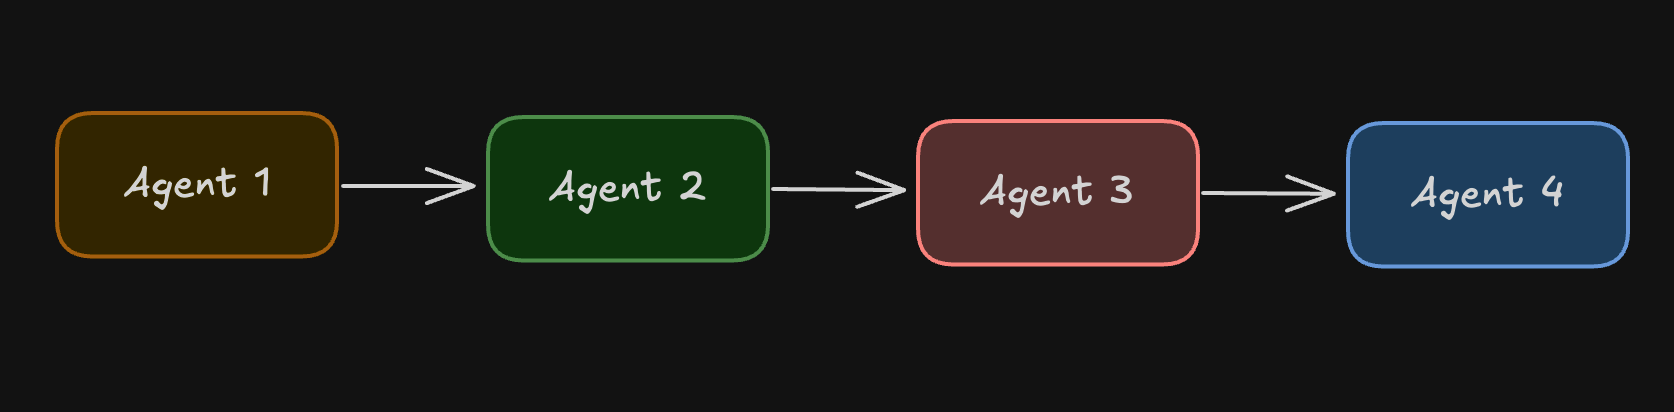

In [7]:
from google.adk.agents import SequentialAgent, LlmAgent, ParallelAgent

# tool
def get_release_year(title: str) -> int:
    """Hard-coded mini DB for demo."""
    return {"The Matrix": 1999,
            "Inception": 2010,
            "Avatar": 2009}.get(title, 2000)

# sub-agents 
year_lookup = LlmAgent(
    name="year_lookup", model=MODEL_GEMINI_FLASH,
    instruction="Return just the release year as an int.",
    tools=[get_release_year],
)

age_counter = LlmAgent(
    name="age_counter", model=MODEL_GEMINI_FLASH,
    instruction="Call years_since(year) and reply with '<N> years'.",
    tools=[years_since],
)

greeter = LlmAgent(
    name="greeter", model=MODEL_GEMINI_FLASH,
    instruction=("You will receive the movie title and its age."
                 "Craft '🎉 Happy <N>th to <Movie Title>!'"),
    generate_content_config=types.GenerateContentConfig(
        max_output_tokens=1024,
        temperature=0.7,
        top_p=0.9
    )
)

#  sequential pipeline
birthday_pipeline = SequentialAgent(
    name="movie_birthday_seq",
    description="Pipeline: lookup year ➜ compute age ➜ greet properly!",
    sub_agents=[year_lookup, age_counter, greeter],
)

runner_seq = Runner(agent=birthday_pipeline, app_name=APP, session_service=session_service)

# Iterate over the async generator to get the response
async for event in runner_seq.run_async(
    user_id=USER_ID,
    session_id=SESSION_ID,
    new_message=types.Content(role="user", parts=[types.Part(text="The Matrix")])
):
    if event.is_final_response() and event.content and event.content.parts:
        print(event.content.parts[0].text)
        break

1999


### Parallel Agent with Tool Use

A ParallelAgent is a workflow wrapper that fires all its sub-agents at once, so independent tasks finish faster than if they ran one-by-one. It’s deterministic (no LLM inside) and shines when each branch can work on its own—like fetching data from several APIs or tools concurrently

#### When you’d reach for it
* Speed-critical pipelines – cut wall-clock time on I/O-heavy steps (e.g., multiple web searches).
* Tool specialisation – every branch can mount the exact tool it needs (Google Search, Vision, BigQuery, etc.).
* Clean aggregation – collect the results later in a merger or next agent, keeping each sub-agent focused and testable.

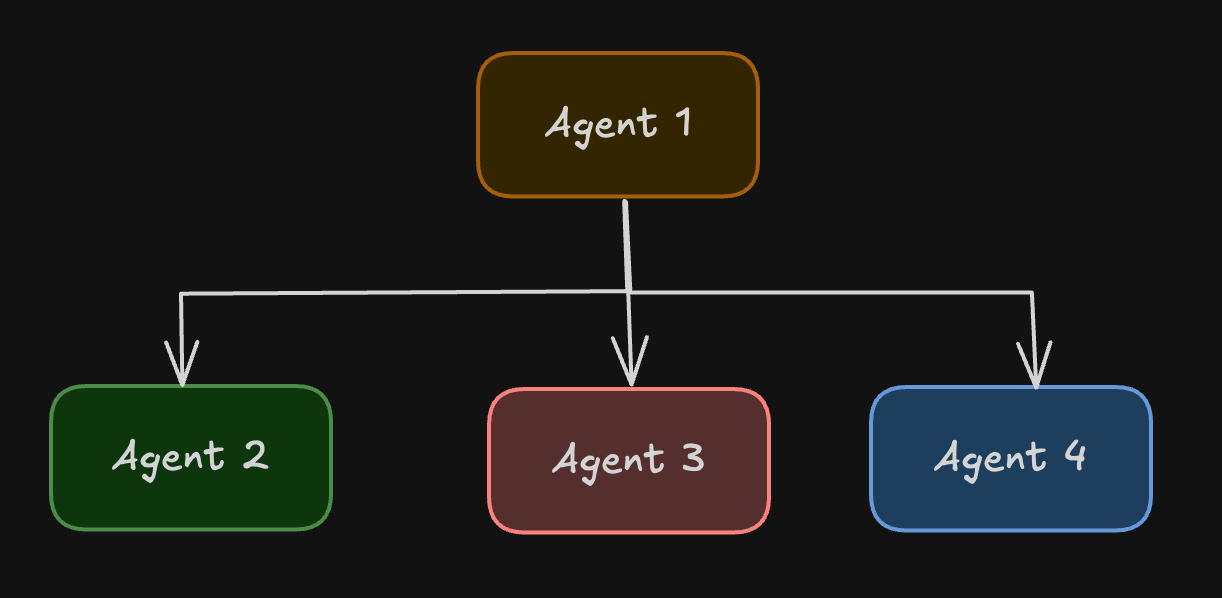

In [ ]:
import re
from google.adk.agents import ParallelAgent

def to_valid_agent_name(console: str) -> str:
    # Replace non-alphanumeric characters with underscores, remove leading digits, and lowercase
    name = re.sub(r'\W+', '_', console)
    name = re.sub(r'^[^a-zA-Z_]+', '', name)
    return f"{name.lower()}_scout"

def make_console_scout(query: str) -> Agent:
    return Agent(
        name=to_valid_agent_name(query), model=MODEL_GEMINI_FLASH,
        instruction=(f"Find 2 freshest rumours or announcements about "
                     f"{query}. Use `google_search`. Reply in • bullets."),
        tools=[google_search],
        generate_content_config=types.GenerateContentConfig(
            max_output_tokens=1024,
            temperature=0.7,
        )
    )

agent1   = make_console_scout("Jeff Bezos wedding")
agent2 = make_console_scout("India's mission to space")
agent3   = make_console_scout("Operation Sindhoor")

news_parallel = ParallelAgent(
    name="news_parallel",
    description="Gets latest buzz on the following in parallel, be detailed.",
    sub_agents=[agent1, agent2, agent3],
)

runner_par = Runner(agent=news_parallel, app_name=APP, session_service=session_service)
results = {}                         # author → text
async for event in runner_par.run_async(
        user_id=USER_ID,
        session_id=SESSION_ID,
        new_message=types.Content(role="user",
                                   parts=[types.Part(text="Latest rumours")])
):
    if event.is_final_response() and event.content:
        results[event.author] = event.content.parts[0].text.replace("**", "")
        if len(results) == len(news_parallel.sub_agents):
            break

for author, text in results.items():
    print(f"{author}: {text}\n")

jeff_bezos_wedding_scout: Here are two of the freshest rumors and announcements about Jeff Bezos' wedding:

*   Jeff Bezos and Lauren Sánchez have begun their multi-day wedding celebration in Venice, Italy, with around 200 guests, including celebrities, politicians, and royalty. The celebrations are expected to last three days. The couple is rumored to have spent between $10 and $20 million on the wedding.
*   The wedding ceremony is expected to be held on the island of San Giorgio Maggiore. The wedding invitation has been mocked online for its amateurish design.


india_s_mission_to_space_scout: Here are two of the most recent updates regarding India's space mission:

*   First Indian astronaut to visit the ISS: Group Captain Shubhanshu Shukla of the Indian Air Force is prepared to fly to the International Space Station (ISS) as part of Axiom Space's Ax-4 mission. This mission was scheduled for May 2025 and marks a significant milestone in India's expanding international space collabo